In [1]:
!nvidia-smi

Tue Aug  6 18:08:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:2B:00.0  On |                  N/A |
|  0%   33C    P8             19W /  350W |     427MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/zanqi/segment-anything-2


In [3]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [4]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [7]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [8]:
# IMAGE_PATH = f"{HOME}/data/dog.jpeg"
IMAGE_PATH = f"../LLaVA/armbench/images/9980.jpg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam2_result = mask_generator.generate(image_rgb)

In [9]:
sam2_result[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 189755,
 'bbox': [0.0, 1.0, 511.0, 381.0],
 'predicted_iou': 0.99609375,
 'point_coords': [[264.0, 18.0]],
 'stability_score': 0.9523190855979919,
 'crop_box': [0.0, 0.0, 512.0, 384.0]}

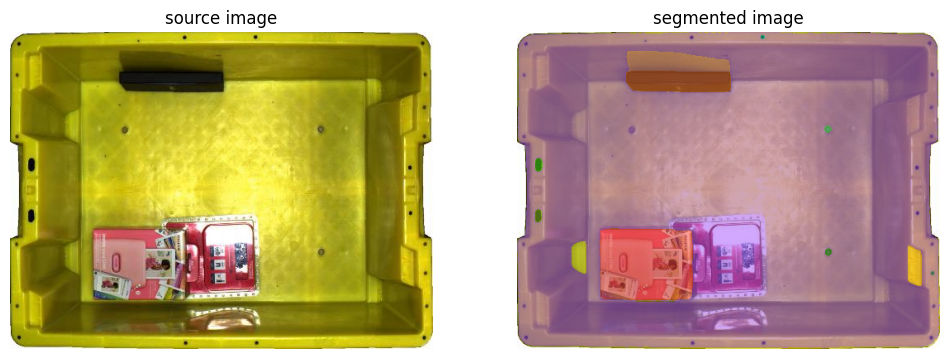

In [10]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

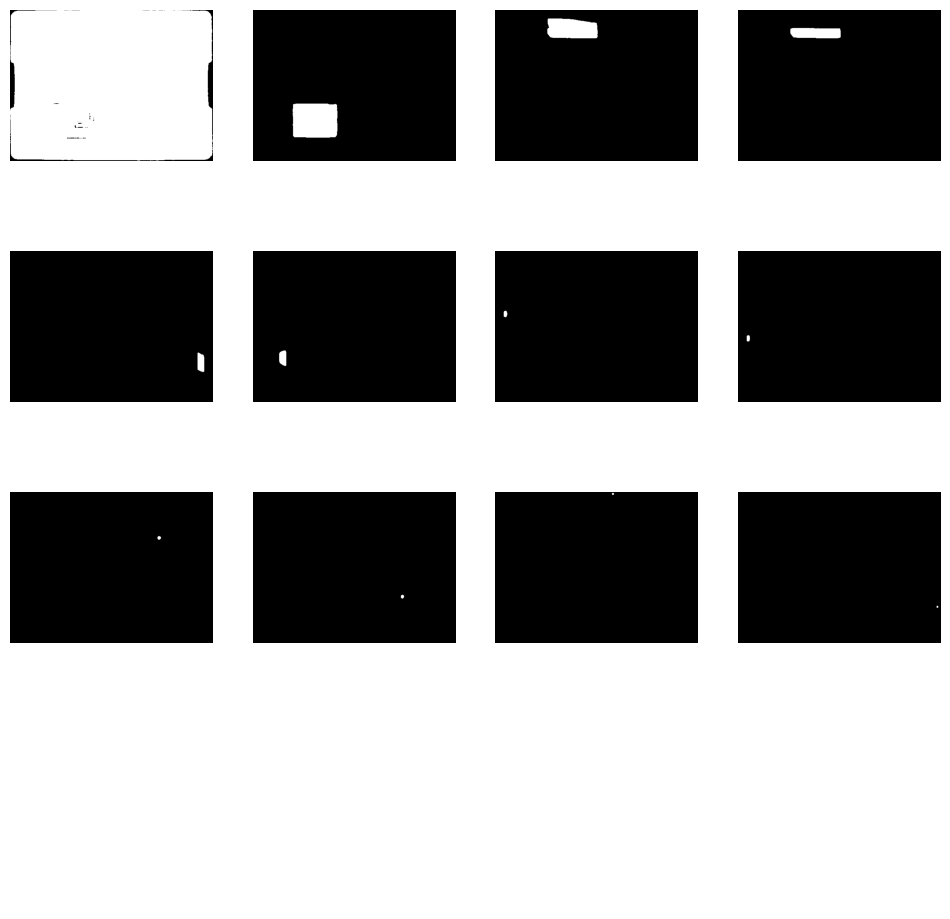

In [11]:
masks = [
    mask["segmentation"]
    for mask in sorted(sam2_result, key=lambda x: x["area"], reverse=True)
]

sv.plot_images_grid(images=masks[:16], grid_size=(4, 4), size=(12, 12))

In [12]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [13]:
sam2_result_2 = mask_generator_2.generate(image_rgb)

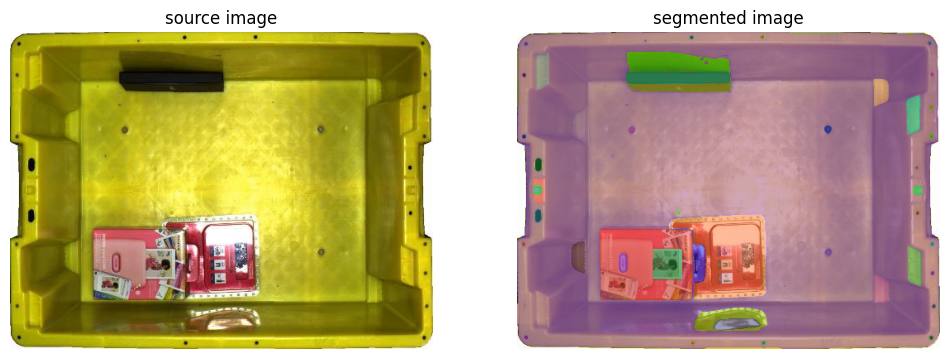

In [14]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


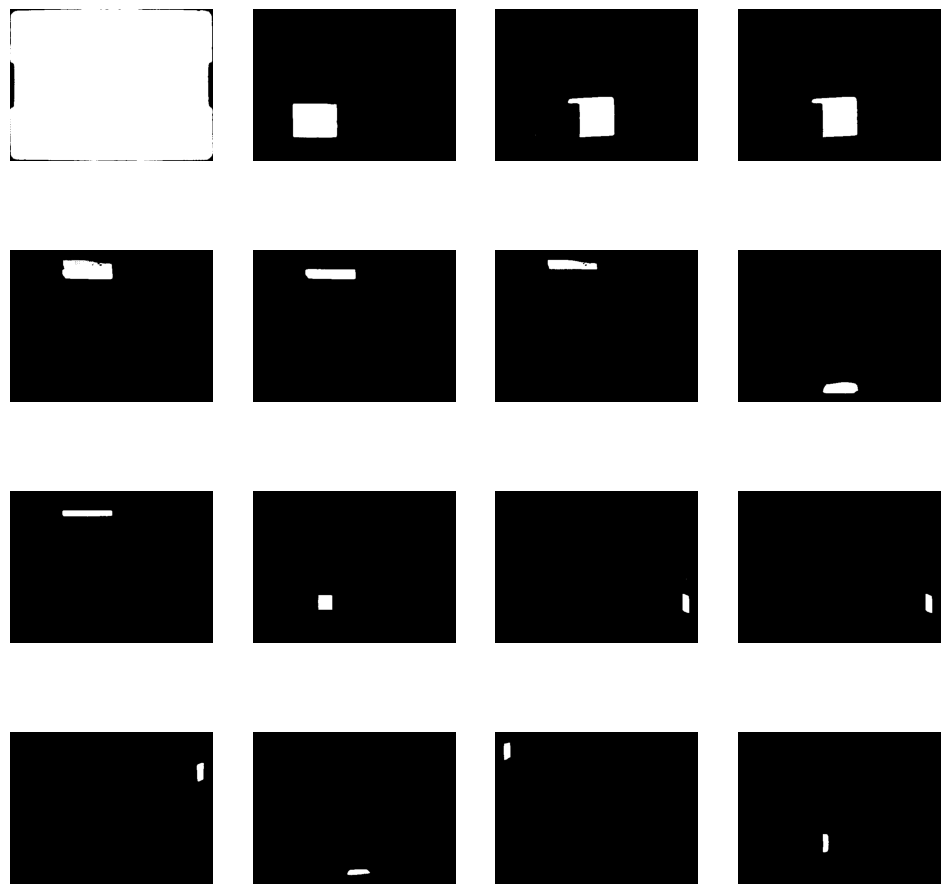

In [15]:
masks = [
    mask["segmentation"]
    for mask in sorted(sam2_result_2, key=lambda x: x["area"], reverse=True)
]

sv.plot_images_grid(images=masks[:16], grid_size=(4, 4), size=(12, 12))

### Prompt

In [16]:
predictor = SAM2ImagePredictor(sam2_model)

In [17]:
# IMAGE_PATH = f"{HOME}/data/dog-2.jpeg"
IMAGE_PATH = f"../LLaVA/armbench/images/9980.jpg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [18]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [19]:
IS_COLAB = False

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [20]:
from jupyter_bbox_widget import BBoxWidget
widget = BBoxWidget(
    image=IMAGE_PATH,
    classes=['apple', 'orange', 'pear'],
)
widget

BBoxWidget(classes=['apple', 'orange', 'pear'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',…

In [21]:
widget.bboxes

[]

In [22]:
default_box = [
    {'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
    {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
    {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
    {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

In [23]:
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

masks = np.squeeze(masks)

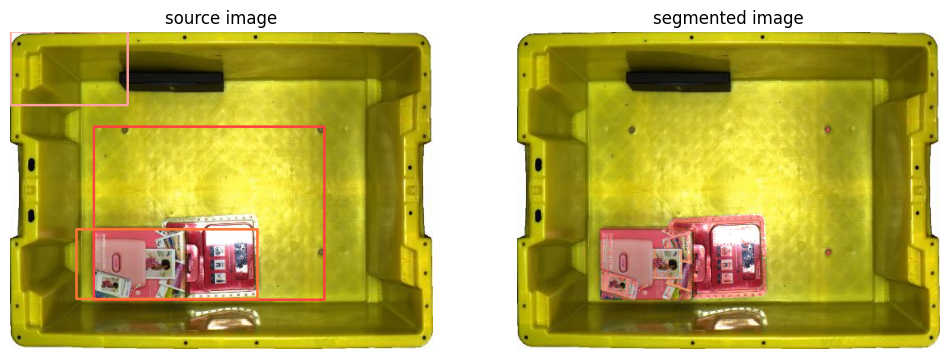

In [24]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [25]:
IS_COLAB = False

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [29]:
widget.bboxes

[{'x': 140, 'y': 263, 'width': 9, 'height': 7, 'label': ''},
 {'x': 258, 'y': 274, 'width': 13, 'height': 9, 'label': ''},
 {'x': 189, 'y': 59, 'width': 13, 'height': 8, 'label': ''}]

In [41]:
default_box = [
    {'x': 100, 'y': 300, 'width': 0, 'height': 0, 'label': ''},
    # {'x': 191, 'y': 665, 'width': 0, 'height': 0, 'label': ''},
    # {'x': 86, 'y': 879, 'width': 0, 'height': 0, 'label': ''},
    # {'x': 425, 'y': 727, 'width': 0, 'height': 0, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
input_label = np.ones(input_point.shape[0])

In [42]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

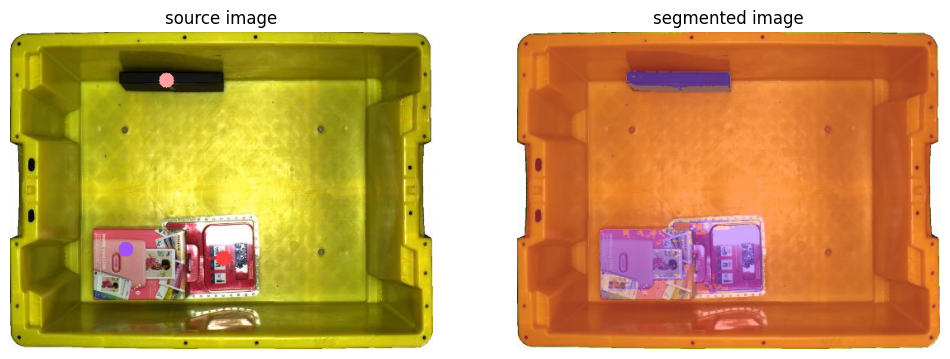

In [43]:

box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=masks), mask=masks.astype(bool))

dots = sv.Detections(xyxy=np.array([[x, y, x, y] for x, y in input_point]))

source_image = sv.DotAnnotator(color_lookup=sv.ColorLookup.INDEX, radius=9).annotate(
    scene=image_bgr.copy(), detections=dots,
)

# source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=["source image", "segmented image"],
)

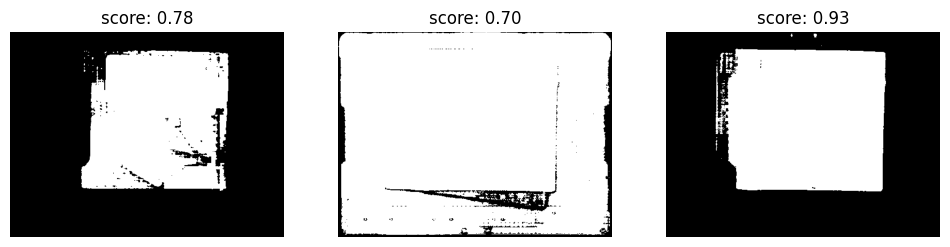

In [55]:
sv.plot_images_grid(
    images=masks[:3],
    titles=[f"score: {score:.2f}" for score in scores],
    grid_size=(1, 3),
    size=(12, 12)
)

### MAP

In [6]:
from PIL import Image
import h5py

f = h5py.File("../LLaVA/armbench512x384_5_all.h5", "r")


def xyxy(mask):
    return [
        int(np.min(np.where(mask)[1])),  # x_min
        int(np.min(np.where(mask)[0])),  # y_min
        int(np.max(np.where(mask)[1])),  # x_max
        int(np.max(np.where(mask)[0])),  # y_max
    ] if np.any(mask) else [0, 0, 0, 0]


def getImgAndMask(i):
    img = Image.fromarray(f["data"][i])
    mask = f["mask"]

    masks = []
    for cat in np.unique(mask[i]):
        if cat == 0 or cat == 255:
            continue
        mask_i = mask[i]
        mask_i = mask_i == cat
        masks.append(mask_i)

    return img, masks


def getbbox(masks):
    boxes = []
    for mask in masks:
        bbox = xyxy(mask)
        boxes.append(bbox)
    return boxes


def pointsInMask(mask, n):
    y, x = np.where(mask)
    points = []
    for _ in range(n):
        i = np.random.randint(len(x))
        point = (x[i], y[i])
        points.append(point)
    return points


def getpoints(masks, n, num_neg_points):
    points = []
    for mi, mask in enumerate(masks):
        points_in_mask = pointsInMask(mask, n)
        if len(masks) == 1:
            inv_mask = np.logical_not(mask)
            neg_points = pointsInMask(inv_mask, num_neg_points)
        else:
            neg_points = [
                pointsInMask(
                    masks[
                        (
                            (mi + i) % len(masks)
                            if (mi + i) % len(masks) != mi
                            else (mi + 1) % len(masks)
                        )
                    ],
                    1,
                )[0]
                for i in range(num_neg_points)
            ]

        points.append(points_in_mask + neg_points)
    return points

In [7]:
import cv2
import json

dataset_json = json.load(open("../LLaVA/armbench/test/dataset.json", "r"))
image_files = [
    os.path.join("../LLaVA/armbench/images", x["image"]) for x in dataset_json
]


predictor = SAM2ImagePredictor(sam2_model)

def getImgBboxesPoints(i, n, num_neg_points):
    img, masks = getImgAndMask(i)
    boxes = getbbox(masks)
    points = getpoints(masks, n, num_neg_points)
    return img, boxes, points

def evalPoints(num_points, num_neg_points):
    preds = []
    targets = []
    pointsList = []
    for image_file in image_files:
        image_bgr = cv2.imread(image_file)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        i = int(image_file.split("/")[-1].split(".")[0])
        img, boxes, points = getImgBboxesPoints(i, num_points, num_neg_points)
        targets.append(np.array([b + [0] for b in boxes]))

        predictor.set_image(image_rgb)
        pred = []
        for i in range(len(boxes)):
            masks, scores, logits = predictor.predict(
                point_coords=points[i],
                point_labels=[1] * num_points + [0] * num_neg_points,
                multimask_output=True,
            )
            # get the mask with the highest score
            best_score_idx = np.argmax(scores)
            best_mask = masks[best_score_idx]

            # get the bounding box of the mask
            bbox = xyxy(best_mask) + [0, 1]
            pred.append(bbox)
        pointsList.append(points)
        preds.append(np.array(pred))
    return preds, targets, pointsList

In [8]:
import pandas as pd

df = pd.DataFrame(
    columns=["num_points", "num_neg_points", "mAP50_90", "mAP50", "mAP75"]
)
for total in [4]:
    for num_points in [2]:
        preds, targets, pointsList = evalPoints(num_points, total - num_points)
        map_metrics = sv.MeanAveragePrecision.from_tensors(
            targets=targets, predictions=preds
        )
        df.loc[len(df)] = [
            num_points,
            total - num_points,
            map_metrics.map50_95,
            map_metrics.map50,
            map_metrics.map75,
        ]
df

,num_points,num_neg_points,mAP50_90,mAP50,mAP75
0,2.0,2.0,0.668323,0.843258,0.736813


In [9]:
import random


def viz(i):
    image_bgr = cv2.imread(image_files[i])
    dots = sv.Detections(
        xyxy=np.array([[x, y, x, y] for points in pointsList[i] for x, y in points]),
        class_id=np.array(
            [j for j in range(len(pointsList[i])) for _ in range(len(pointsList[i][j]))]
        ),
    )

    source_image = sv.DotAnnotator(
        color_lookup=sv.ColorLookup.CLASS, radius=20
    ).annotate(
        scene=image_bgr.copy(),
        detections=dots,
    )

    box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX, thickness=3)
    detections = sv.Detections(xyxy=preds[i][:, :4], mask=None)
    segmented_image = box_annotator.annotate(
        scene=image_bgr.copy(), detections=detections
    )
    target_image = box_annotator.annotate(
        scene=image_bgr.copy(),
        detections=sv.Detections(xyxy=targets[i][:, :4], mask=None),
    )
    # segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    sv.plot_images_grid(
        images=[source_image, segmented_image, target_image],
        grid_size=(1, 3),
        titles=["prompt", "prediction", "target"],
    )

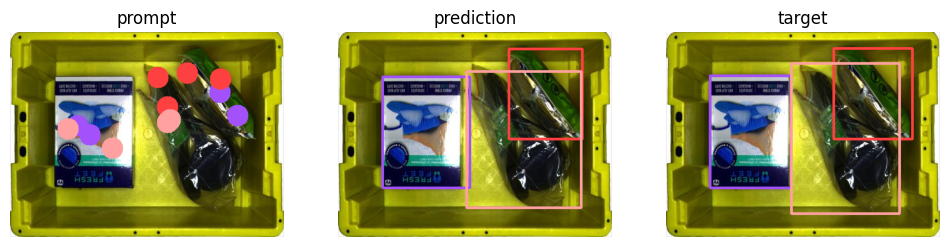

In [20]:
viz(random.randint(0, len(image_files)))

In [122]:
np.clip(1, 0, 2)

1

In [22]:
def evalBoxes(dx, dy, size_percent):
    preds = []
    targets = []
    boxesList = []
    for image_file in image_files:
        image_bgr = cv2.imread(image_file)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        i = int(image_file.split("/")[-1].split(".")[0])
        img, boxes, _ = getImgBboxesPoints(i, 0, 0)
        targets.append(np.array([b + [0] for b in boxes]))
        # resize the boxes to size_percent
        boxes = [
            [
                np.clip(xmin + ((xmax - xmin) - (xmax - xmin) * size_percent) / 2 + dx * (xmax-xmin), 0, 512),
                np.clip(ymin + ((ymax - ymin) - (ymax - ymin) * size_percent) / 2 + dy * (ymax-ymin), 0, 384),
                np.clip(xmax - ((xmax - xmin) - (xmax - xmin) * size_percent) / 2 + dx * (xmax-xmin), 0, 512),
                np.clip(ymax - ((ymax - ymin) - (ymax - ymin) * size_percent) / 2 + dy * (ymax-ymin), 0, 384),
            ]
            for xmin, ymin, xmax, ymax in boxes
        ]

        predictor.set_image(image_rgb)
        pred = []
        for i in range(len(boxes)):
            masks, scores, logits = predictor.predict(
                box=boxes[i],
                multimask_output=True,
            )
            # get the mask with the highest score
            best_score_idx = np.argmax(scores)
            best_mask = masks[best_score_idx]

            # get the bounding box of the mask
            bbox = xyxy(best_mask) + [0, 1]
            pred.append(bbox)
        boxesList.append(boxes)
        preds.append(np.array(pred))
    return preds, targets, boxesList

In [23]:
df = pd.DataFrame(columns=["dx", "dy", "resize", "mAP50_90", "mAP50", "mAP75"])
for dx, dy in [(0, 0), (.15, .15)]:
    for size_percentage in [1, 1.15]:
        preds, targets, boxesList = evalBoxes(dx, dy, size_percentage)
        map_metrics = sv.MeanAveragePrecision.from_tensors(
            targets=targets, predictions=preds
        )
        df.loc[len(df)] = [
            dx,
            dy,
            size_percentage,
            map_metrics.map50_95,
            map_metrics.map50,
            map_metrics.map75,
        ]
df

,dx,dy,resize,mAP50_90,mAP50,mAP75
0,0.00,0.00,1.00,0.880051,0.989062,0.978379
1,0.00,0.00,1.15,0.829854,0.973044,0.936541
2,0.15,0.15,1.00,0.424755,0.777907,0.364252
3,0.15,0.15,1.15,0.535131,0.871079,0.502777


In [24]:
import random


def vizbox(i):
    image_bgr = cv2.imread(image_files[i])

    detections = sv.Detections(xyxy=np.array(boxesList[i]), mask=None)
    source_image = sv.BoxAnnotator(
        color_lookup=sv.ColorLookup.INDEX, thickness=3
    ).annotate(
        scene=image_bgr.copy(),
        detections=detections,
    )

    box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX, thickness=3)
    detections = sv.Detections(xyxy=preds[i][:, :4], mask=None)
    segmented_image = box_annotator.annotate(
        scene=image_bgr.copy(), detections=detections
    )
    target_image = box_annotator.annotate(
        scene=image_bgr.copy(),
        detections=sv.Detections(xyxy=targets[i][:, :4], mask=None),
    )

    sv.plot_images_grid(
        images=[source_image, segmented_image, target_image],
        grid_size=(1, 3),
        titles=["prompt", "prediction", "target"],
    )

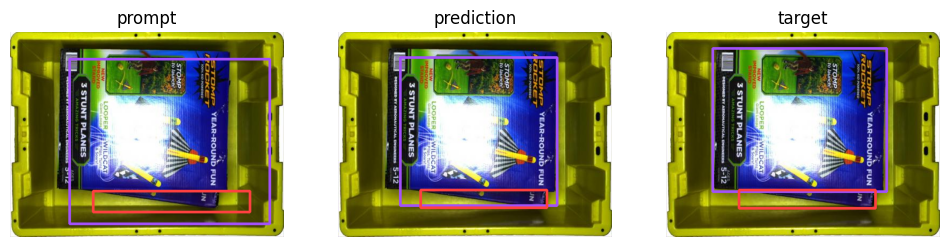

In [27]:
vizbox(random.randint(0, len(image_files)))

Single Random point, point label is category number

MeanAveragePrecision(map50_95=0.32869706453959885, map50=0.4620786418410024, map75=0.3200797533226392, per_class_ap50_95=array([[0.46207864, 0.44006856, 0.41681288, 0.38467401, 0.34223039,
        0.32007975, 0.28583787, 0.25896638, 0.22667958, 0.14954257]]))

Single Random point, point label is 1

MeanAveragePrecision(map50_95=0.615241927234776, map50=0.7614219228318642, map75=0.6725077072385721, per_class_ap50_95=array([[0.76142192, 0.74584039, 0.73278002, 0.7176939 , 0.7001804 ,
        0.67250771, 0.61433173, 0.55454869, 0.42456063, 0.22855389]]))

MeanAveragePrecision(map50_95=0.648729106486941,
                     map50=0.7984967483887067,
                     map75=0.7063072103198932,
                     per_class_ap50_95=array([[0.79849675, 0.79064054, 0.77523759, 0.76121039, 0.72525837,
        0.70630721, 0.65033212, 0.58695806, 0.45531361, 0.23753642]]))
        
MeanAveragePrecision(map50_95=0.6053786362610134,
                     map50=0.745925040831352,
                     map75=0.6658507554577506,
                     per_class_ap50_95=array([[0.74592504, 0.72002721, 0.70037177, 0.68523213, 0.67592551,
        0.66585076, 0.62271836, 0.55520875, 0.44114984, 0.24137699]]))

Two points

MeanAveragePrecision(map50_95=0.6868775308593725,
                     map50=0.8394055993184215,
                     map75=0.744445657451317,
                     per_class_ap50_95=array([[0.8394056 , 0.82662138, 0.81622117, 0.80596024, 0.788691  ,
        0.74444566, 0.68160276, 0.61098061, 0.49930349, 0.2555434 ]]))

One point, one negative
MeanAveragePrecision(map50_95=0.6028578509386598,
                     map50=0.731620524970069,
                     map75=0.6470658865253275,
                     per_class_ap50_95=array([[0.73162052, 0.71677448, 0.71677448, 0.69813424, 0.67660366,
        0.64706589, 0.60834922, 0.5462934 , 0.4297082 , 0.25725442]]))

Three

MeanAveragePrecision(map50_95=0.7178831957407502,
                     map50=0.875471928027351,
                     map75=0.7712294232173749,
                     per_class_ap50_95=array([[0.87547193, 0.86150077, 0.85813459, 0.85554742, 0.8098277 ,
        0.77122942, 0.72191339, 0.64926019, 0.52226578, 0.25368078]]))

Two points, one negative
MeanAveragePrecision(map50_95=0.6767502925719195,
                     map50=0.8469095736021078,
                     map75=0.7184337109997052,
                     per_class_ap50_95=array([[0.84690957, 0.82477941, 0.82191646, 0.79666842, 0.75828696,
        0.71843371, 0.65729804, 0.61056435, 0.48375808, 0.24888793]]))

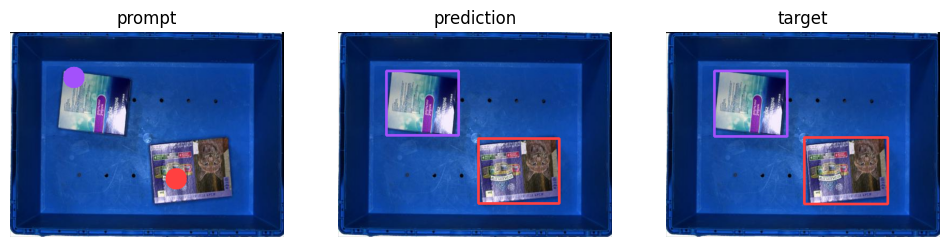
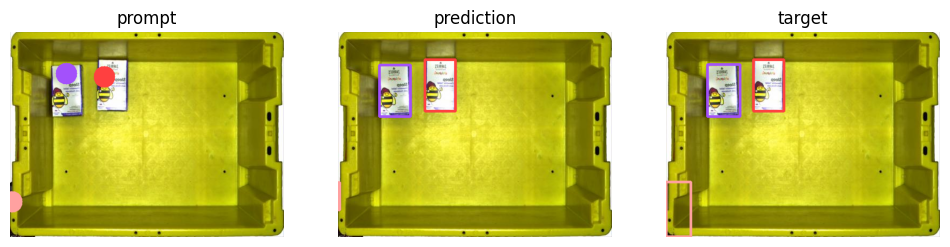

Single object neg points

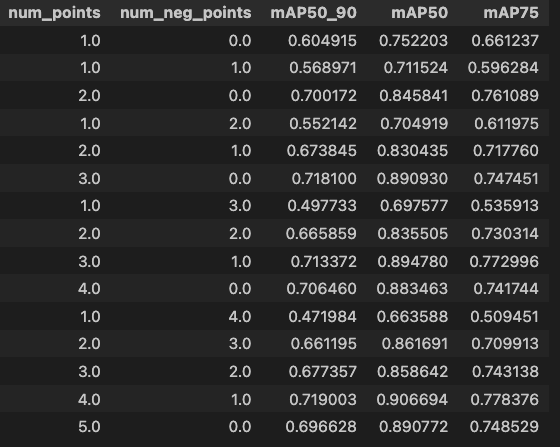

Multi object neg points

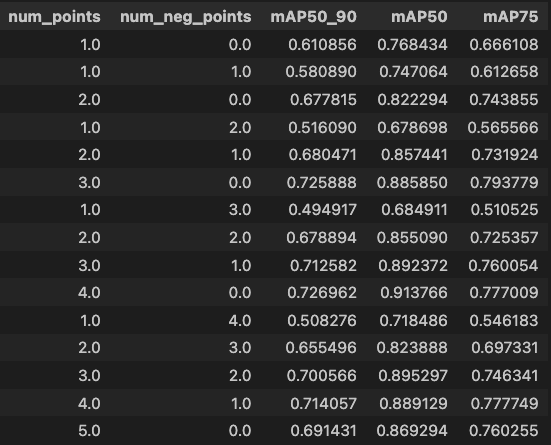



Single output

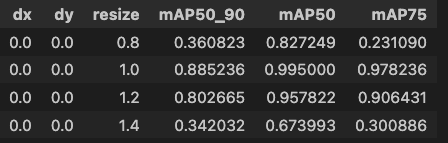

Multi output

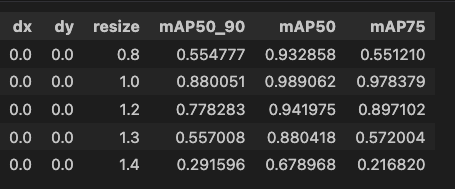

Multi output, clip box

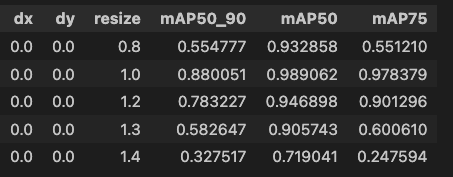